In [110]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [111]:
main_dir='/cloud/skogsstyrelsen_1c_attempt_2/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [112]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [113]:
model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000','cot_model/5/model_it_2000000',
                  'cot_model/6/model_it_2000000','cot_model/7/model_it_2000000',
                  'cot_model/8/model_it_2000000','cot_model/9/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]


In [114]:
main_filepath='pytorch_models/antons_final_model_trans'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
index_median=1

In [115]:
pairs_all=[]
pairs_all_ix=[]
ims_all=[]
cots_all=[]
temporals_all=[]
divide=10000
for i,dir in enumerate(directories):
    print('dir '+str(i)+' of '+str(len(directories)))
    pairs=[]
    pairs_ix=[]
    #Get temporals for directory
    temporals_t=glob.glob(main_dir+dir+'/*.nc')
    temporals=[]
    for t in temporals_t:
        temporals.append(t.split('/')[-1].split('.')[0])
    temporals_all.append(temporals)
    ims=[]
    cots=[]
    for j,temp in enumerate(temporals):
        print('     Temporal '+str(j)+' of '+str(len(temporals)))

        loaded_data = xr.open_dataset(main_dir+dir+'/'+temp+'.nc', engine='netcdf4', decode_times=True)
        nodata = loaded_data.attrs.get("nodata", None)
        loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
        variables=loaded_data.variables

        if int(temp.split('-')[0])>=2022: #Add offset to all data past 2022
            offset=-1000
        else:
            offset=0
        ## Get bands ##
        b02=(np.clip(variables['b02'].data[0,:,:],offset,10000)+offset)/divide
        b03=(np.clip(variables['b03'].data[0,:,:],offset,10000)+offset)/divide
        b04=(np.clip(variables['b04'].data[0,:,:],offset,10000)+offset)/divide
        b05=(np.clip(variables['b05'].data[0,:,:],offset,10000)+offset)/divide
        b06=(np.clip(variables['b06'].data[0,:,:],offset,10000)+offset)/divide
        b07=(np.clip(variables['b07'].data[0,:,:],offset,10000)+offset)/divide
        b08=(np.clip(variables['b08'].data[0,:,:],offset,10000)+offset)/divide
        b8a=(np.clip(variables['b8a'].data[0,:,:],offset,10000)+offset)/divide
        b09=(np.clip(variables['b09'].data[0,:,:],offset,10000)+offset)/divide
        b10=(np.clip(variables['b10'].data[0,:,:],offset,10000)+offset)/divide
        b11=(np.clip(variables['b11'].data[0,:,:],offset,10000)+offset)/divide
        b12=(np.clip(variables['b12'].data[0,:,:],offset,10000)+offset)/divide
        sun_z=variables['sun_zenith']

        ## Save image ##
        im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
        im[:,:,0]=b02
        im[:,:,1]=b03
        im[:,:,2]=b04
        im[:,:,3]=b05
        im[:,:,4]=b06
        im[:,:,5]=b07
        im[:,:,6]=b08
        im[:,:,7]=b8a
        im[:,:,8]=b09
        im[:,:,9]=b10
        im[:,:,10]=b11
        im[:,:,11]=b12
        im[:,:,12]=sun_z


        #Reshape and prepare COT estimation
        im_shape=np.shape(im)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r - means) / stds
        image_input_tens=torch.Tensor(inputs).to(device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.015*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2

        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])
        cots.append(im_pred_cot_t_r)
        im_wcot=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
        im_wcot[:,:,0:13]=im
        im_wcot[:,:,13]=im_pred_cot_t
        ims.append(im_wcot)
    
    cloud_cov=0.05
    for j,cot in enumerate(cots):
        frac_cloud=np.sum(cot>0)/np.size(cot)
        if frac_cloud>=cloud_cov: #If more than 5 % clouds
            if j<(len(cots)-1):
                if np.sum(cots[j+1]>1)/np.size(cots[j+1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j+1],temporals[j])
                    pair_ix=(j+1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
            elif j>0:
                if np.sum(cots[j-1]>0)/np.size(cots[j-1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j-1],temporals[j])
                    pair_ix=(j-1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
    pairs_all.append(pairs)
    pairs_all_ix.append(pairs_ix)
    ims_all.append(ims)

dir 0 of 22
     Temporal 0 of 13
     Temporal 1 of 13
     Temporal 2 of 13
     Temporal 3 of 13
     Temporal 4 of 13
     Temporal 5 of 13


     Temporal 6 of 13
     Temporal 7 of 13
     Temporal 8 of 13
     Temporal 9 of 13
     Temporal 10 of 13
     Temporal 11 of 13
     Temporal 12 of 13
dir 1 of 22
     Temporal 0 of 20
     Temporal 1 of 20
     Temporal 2 of 20
     Temporal 3 of 20
     Temporal 4 of 20
     Temporal 5 of 20
     Temporal 6 of 20
     Temporal 7 of 20
     Temporal 8 of 20
     Temporal 9 of 20
     Temporal 10 of 20
     Temporal 11 of 20
     Temporal 12 of 20
     Temporal 13 of 20
     Temporal 14 of 20
     Temporal 15 of 20
     Temporal 16 of 20
     Temporal 17 of 20
     Temporal 18 of 20
     Temporal 19 of 20
dir 2 of 22
     Temporal 0 of 18
     Temporal 1 of 18
     Temporal 2 of 18
     Temporal 3 of 18
     Temporal 4 of 18
     Temporal 5 of 18
     Temporal 6 of 18
     Temporal 7 of 18
     Temporal 8 of 18
     Temporal 9 of 18
     Temporal 10 of 18
     Temporal 11 of 18
     Temporal 12 of 18
     Temporal 13 of 18
     Temporal 14 of 18
     Temporal 15 of 18
     Tempor

In [116]:
for i,pairs in enumerate(pairs_all):
    for j,pair in enumerate(pairs):
        print(pair)
        print(pairs_all_ix[i][j])
        

('2023-04-21', '2023-04-19')
(7, 6)
('2023-05-13', '2023-05-11')
(6, 5)
('2023-08-29', '2023-07-23')
(13, 12)
('2023-07-20', '2023-07-08')
(18, 17)
('2023-04-16', '2023-04-03')
(9, 8)
('2018-08-27', '2018-08-25')
(15, 14)
('2018-09-06', '2018-09-04')
(20, 19)
('2021-08-12', '2021-08-11')
(123, 122)
('2023-06-15', '2023-06-05')
(6, 5)
('2023-07-10', '2023-08-24')
(18, 19)
('2023-04-16', '2023-04-03')
(9, 8)
('2023-08-14', '2023-07-22')
(25, 24)


In [117]:
pairs_count=0
for pairs in pairs_all:
    for pair in pairs:
        pairs_count+=1

In [118]:
pairs_count

12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


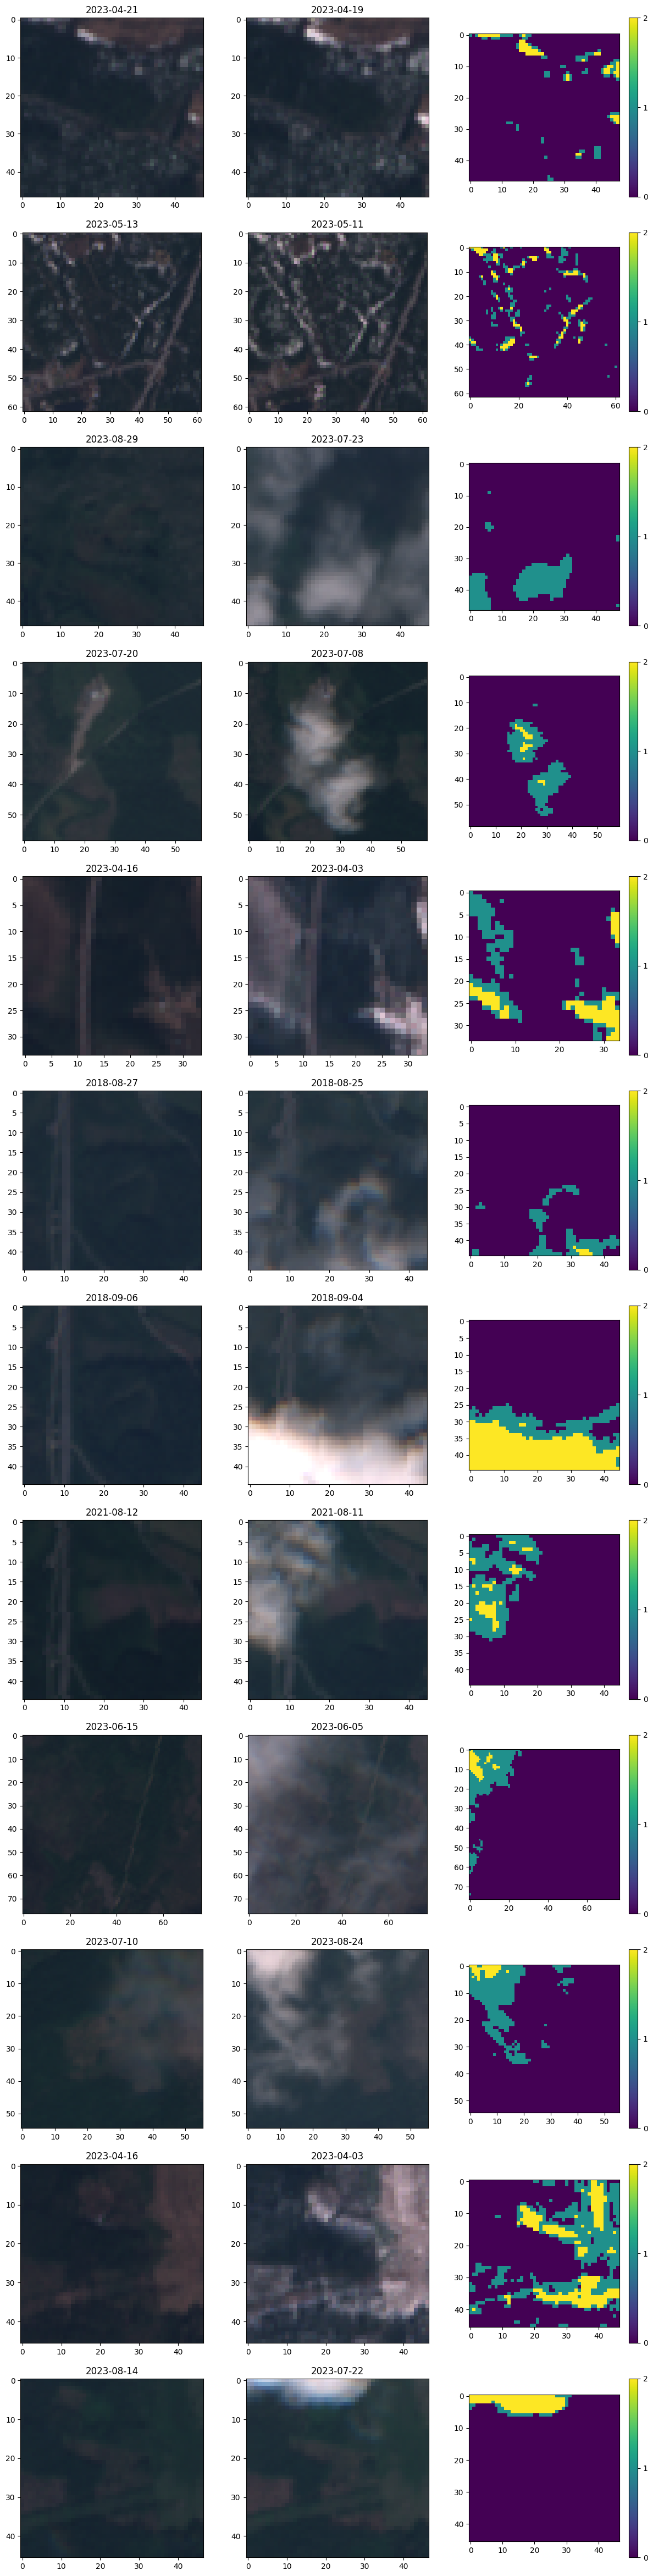

In [119]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]

    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [120]:
remove_pairs=np.array([0,1,5,10,12,13])

In [121]:
pairs_all_new=[]
pairs_all_ix_new=[]
#Fix Tomorrow
p_c=0
for i,pairs in enumerate(pairs_all):
    pairs_tmp=[]
    pairs_ix_tmp=[]
    for j,pair in enumerate(pairs):

        if np.sum(remove_pairs==p_c)==0:
            pairs_tmp.append(pair)
            pairs_ix_tmp.append(pairs_all_ix[i][j])

        p_c+=1
    
    pairs_all_new.append(pairs_tmp)
    pairs_all_ix_new.append(pairs_ix_tmp)


In [122]:
pairs_count=0
for pairs in pairs_all_new:
    for pair in pairs:
        pairs_count+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


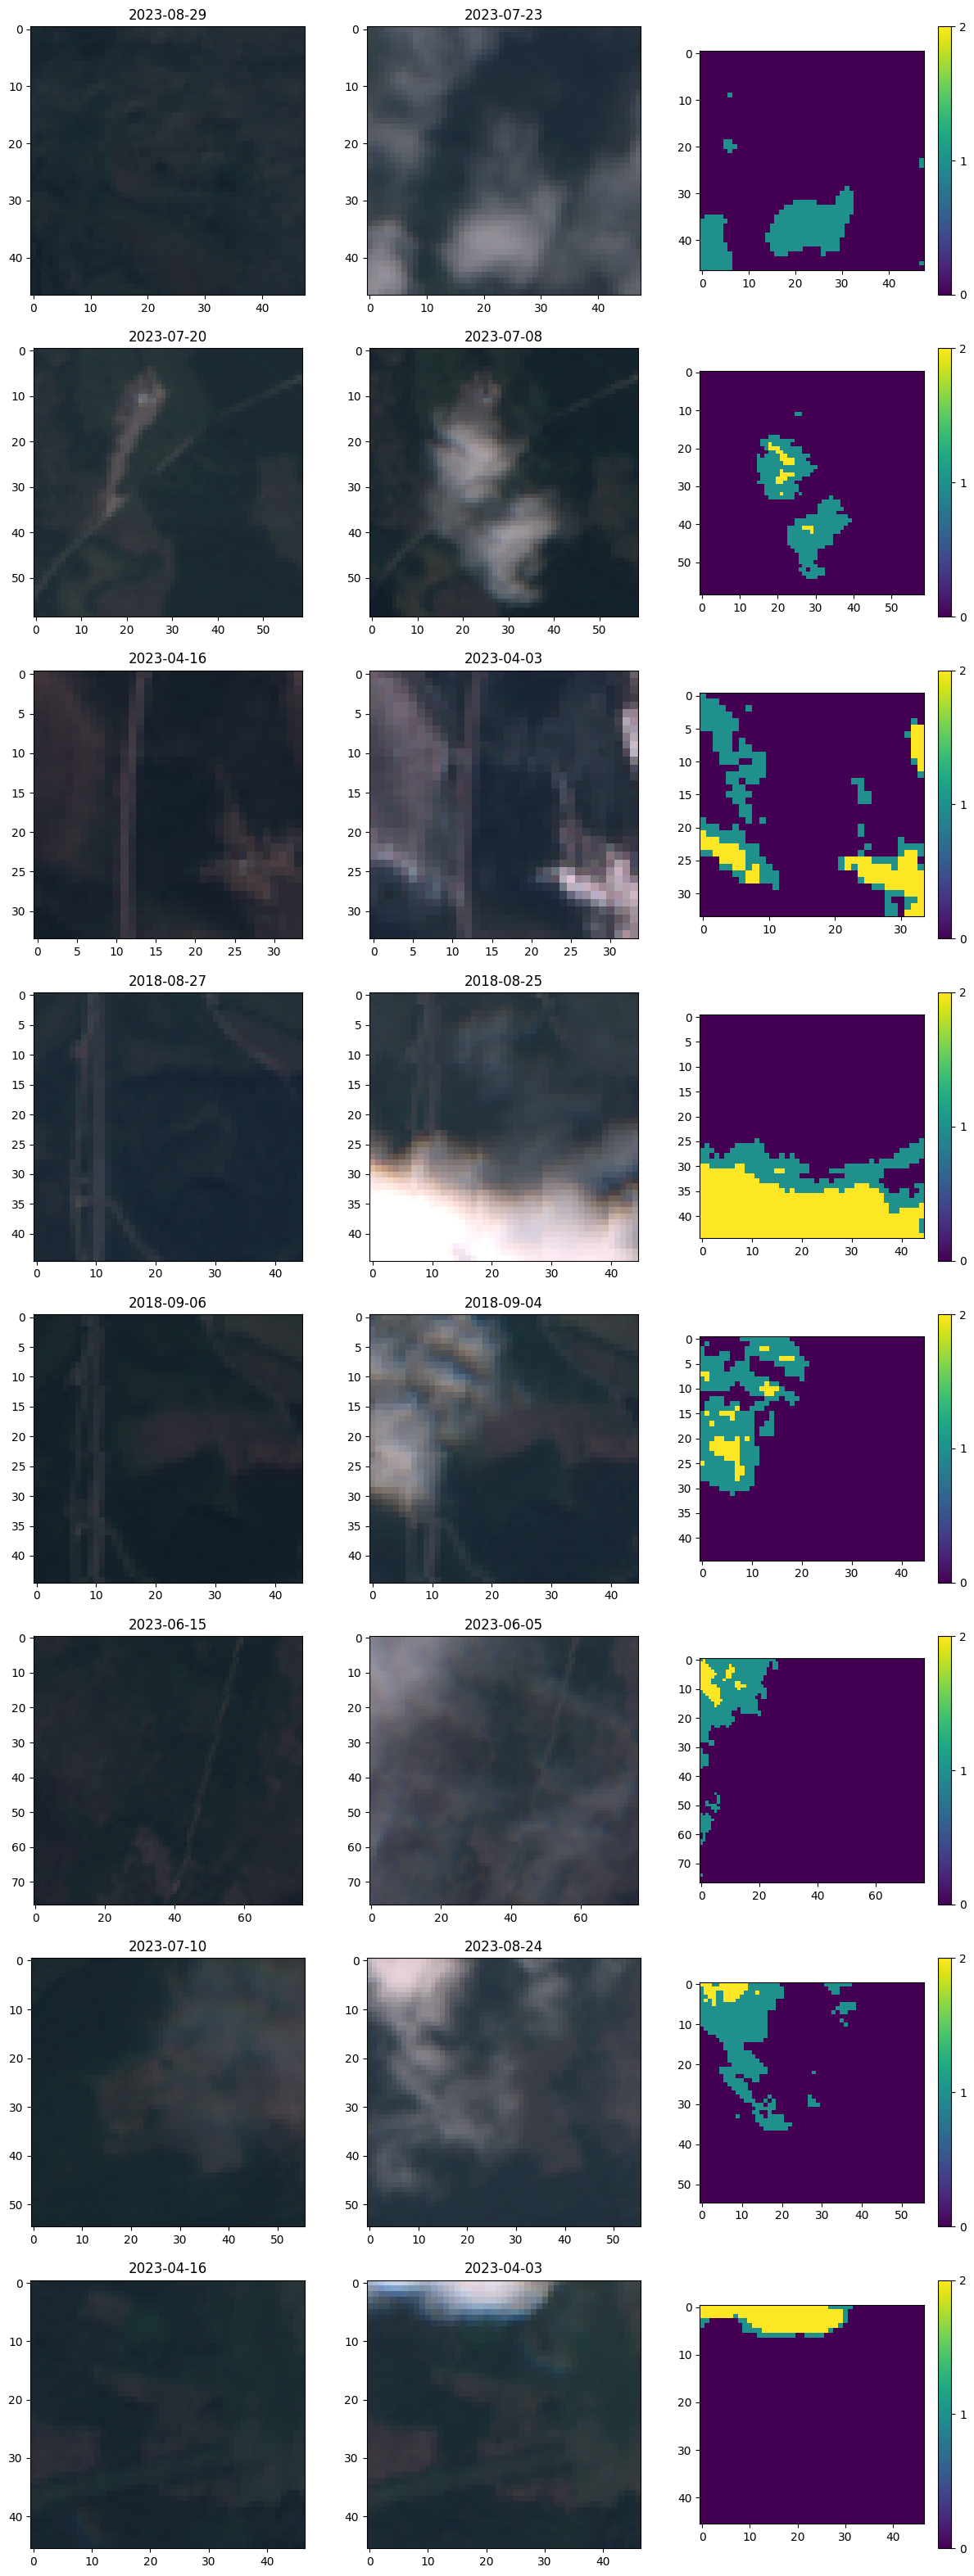

In [123]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix_new[i]

    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [124]:
pairs_all_=pairs_all_new
pairs_all_ix=pairs_all_ix_new

In [125]:
# Make predictions
ims_preds_all=[]
ims_unc_all=[]
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=[]
    ims_unc=[]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        ## Reshape cloudy data
        im_shape=np.shape(im_cloud)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_cot_t_r=im_cloud_r[:,-1]
        #One hot encode cot
        cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
        cot_one_hot[im_pred_cot_t_r==0,0]=1
        cot_one_hot[im_pred_cot_t_r==1,1]=1
        cot_one_hot[im_pred_cot_t_r==2,2]=1

        ## append cot estimation to input data ##
        im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+2))
        im_cloud_r_c[:,0:13]=im_cloud_r[:,0:13]
        im_cloud_r_c[:,13:16]=cot_one_hot

        ## Make prediction
        for i,model in enumerate(models):
            if i==0:
                pred=model.predict(im_cloud_r_c)
            else:   
                pred=pred+model.predict(im_cloud_r_c)
        pred=pred/len(models)

        ##Reshape back
        im_shape_pred=(im_shape[0],im_shape[1],12)
        im_pred=np.zeros(im_shape_pred)
        im_unc=np.zeros(im_shape_pred)
        for i in range(im_shape_pred[2]):
            im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
            im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])
        ims_preds.append(im_pred)
        ims_unc.append(im_unc)

    ims_preds_all.append(ims_preds)
    ims_unc_all.append(ims_unc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


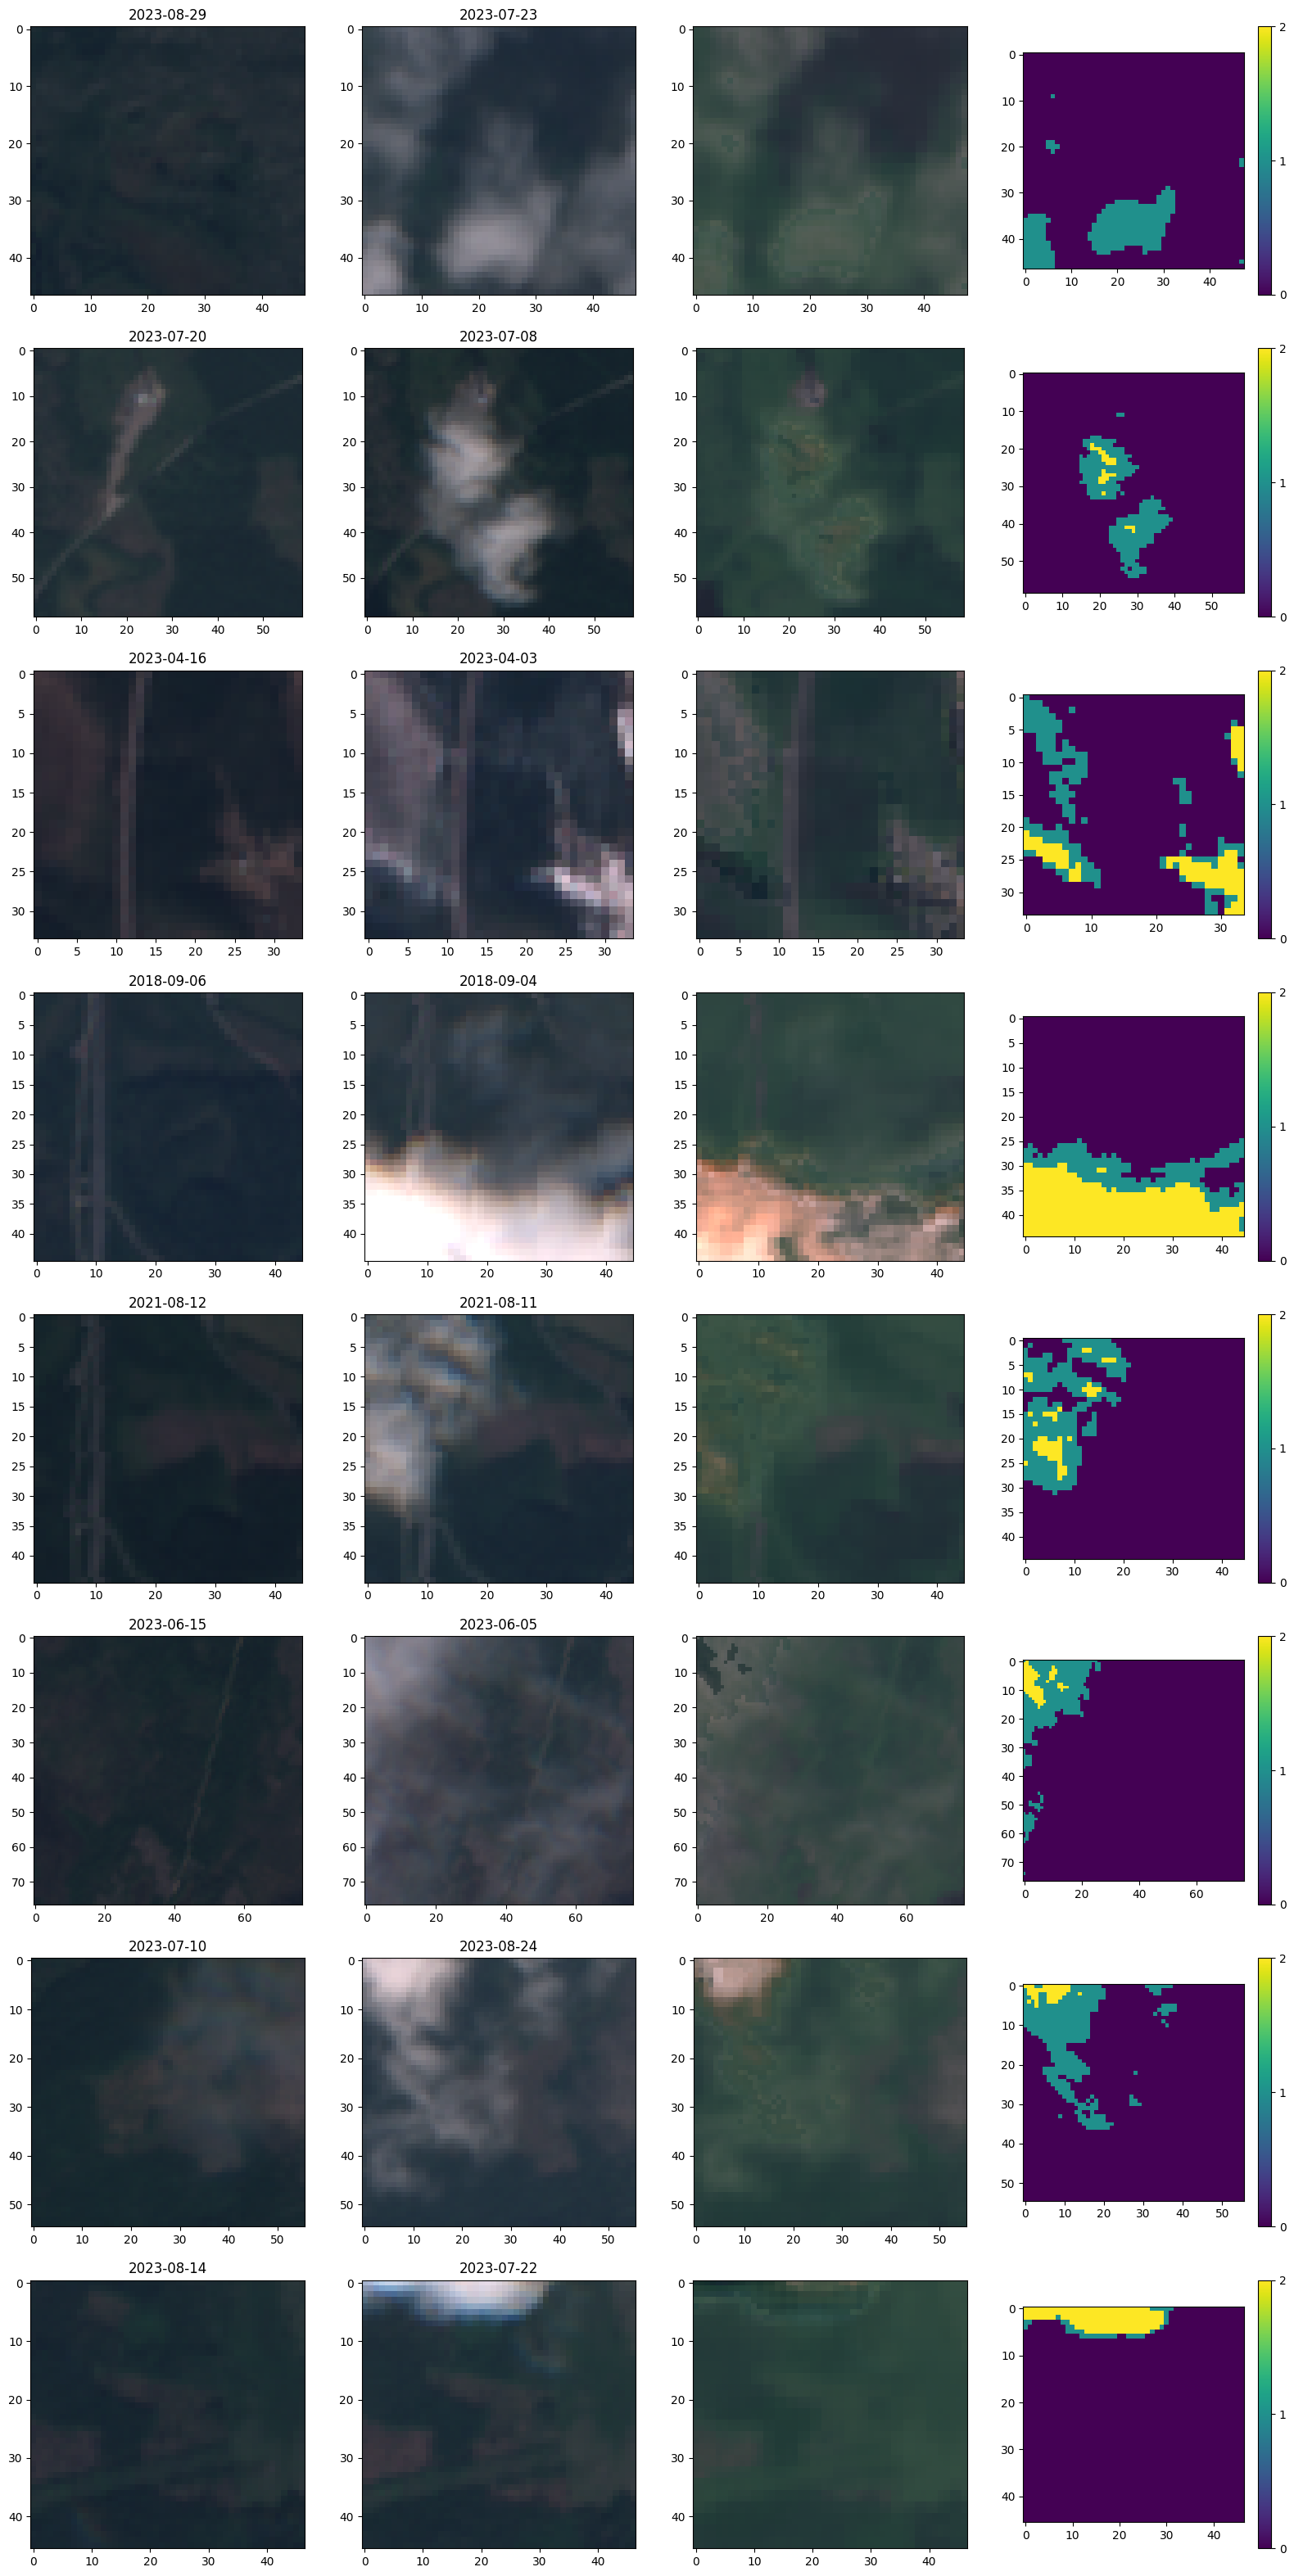

In [126]:
ncols=4
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=preds[j]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        axs[pair_c,2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

        im_c=axs[pair_c,3].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,3],ticks=[0,1,2])
        pair_c+=1

## Evaluate predictions

### NMSE

In [127]:
NMSEs_og=np.zeros((pairs_count,12))
NMSEs_pred=np.zeros((pairs_count,12))

p_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
        norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
        norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
        norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

        NMSE_og=norm_og/norm_gt
        NMSE_pred=norm_pred/norm_gt

        NMSEs_og[p_c,:]=NMSE_og
        NMSEs_pred[p_c,:]=NMSE_pred
        p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

In [128]:
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

NMSE before correction, Band 2: 6.596030376919363
NMSE after correction, Band 2: 0.2465859849816834
 
NMSE before correction, Band 3: 17.970906146202413
NMSE after correction, Band 3: 1.8129990323165368
 
NMSE before correction, Band 4: 95.65060065721286
NMSE after correction, Band 4: 24.166860276970148
 
NMSE before correction, Band 5: 25.681282646904712
NMSE after correction, Band 5: 8.328144501652273
 
NMSE before correction, Band 6: 1.3803580258812889
NMSE after correction, Band 6: 0.5353477975389626
 
NMSE before correction, Band 7: 0.741280093274015
NMSE after correction, Band 7: 0.3350291375944117
 
NMSE before correction, Band 8: 0.5890778375822021
NMSE after correction, Band 8: 0.36974661069100573
 
NMSE before correction, Band 8A: 0.5227275073137015
NMSE after correction, Band 8A: 0.2977332277553088
 
NMSE before correction, Band 9: 11.21895272163378
NMSE after correction, Band 9: 3.4928186455796295
 
NMSE before correction, Band 10: 12.2903406388338
NMSE after correction, Ba

### Percent from ground truth

In [129]:
in_og=np.zeros((pairs_count,12))
in_pred=np.zeros((pairs_count,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]


            im_in_percent=np.abs(im_pred_b-im_truth_b) <= percent*im_truth_b
            im_in_percent_c=np.abs(im_cloud_b-im_truth_b) <= percent*im_truth_b

            in_og[p_c,k]=np.sum(im_in_percent_c)/np.size(im_in_percent_c)
            in_pred[p_c,k]=np.sum(im_in_percent)/np.size(im_in_percent)

        p_c+=1

mean_in_og=np.mean(in_og,axis=0)
mean_in_pred=np.mean(in_pred,axis=0)

In [130]:
print('Percent pixels within '+str(percent*100)+' percent from ground truth')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_in_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_in_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_in_pred[i]))    

    print(' ')

Percent pixels within 20.0 percent from ground truth
 
OG, Band 2: 0.32209868769944816
Pred, Band 2: 0.3191470625705949
 
OG, Band 3: 0.2903260356116024
Pred, Band 3: 0.08289473373637954
 
OG, Band 4: 0.19543007121805522
Pred, Band 4: 0.1931419396919733
 
OG, Band 5: 0.24525063791675528
Pred, Band 5: 0.10726136196304274
 
OG, Band 6: 0.32190726311102247
Pred, Band 6: 0.192598570785642
 
OG, Band 7: 0.3592869408067389
Pred, Band 7: 0.3016728844665944
 
OG, Band 8: 0.3759733587646688
Pred, Band 8: 0.3748068370695531
 
OG, Band 8A: 0.38340912658723925
Pred, Band 8A: 0.42545040657594035
 
OG, Band 9: 0.3746364985233438
Pred, Band 9: 0.4699393686215012
 
OG, Band 10: 0.17079096405712849
Pred, Band 10: 0.11353751608297166
 
OG, Band 11: 0.2887010936623312
Pred, Band 11: 0.06218983392774624
 
OG, Band 12: 0.23765287250097225
Pred, Band 12: 0.06397349846265936
 


In [131]:
abs_distances_og=np.zeros((pairs_count,12))
abs_distances_pred=np.zeros((pairs_count,12))

p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]

            abs_dist_pred=np.abs(im_pred_b-im_truth_b)
            abs_dist_og=np.abs(im_cloud_b-im_truth_b)

            abs_distances_og[p_c,k]=np.mean(abs_dist_og)
            abs_distances_pred[p_c,k]=np.mean(abs_dist_pred)

        p_c+=1

mean_dist_og=np.mean(abs_distances_og,axis=0)
mean_dist_pred=np.mean(abs_distances_pred,axis=0)

In [132]:
print('Mean Absolute distance to ground truth: ')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_dist_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_dist_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_dist_pred[i]))    

    print(' ')

Mean Absolute distance to ground truth: 
 
OG, Band 2: 0.05966921724041484
Pred, Band 2: 0.032812721716405806
 
OG, Band 3: 0.05818532010999457
Pred, Band 3: 0.05492851942584081
 
OG, Band 4: 0.06522797082513124
Pred, Band 4: 0.0452471127883932
 
OG, Band 5: 0.06700934783076716
Pred, Band 5: 0.06644848454902355
 
OG, Band 6: 0.07299855917716169
Pred, Band 6: 0.08630719601629949
 
OG, Band 7: 0.0771373904197677
Pred, Band 7: 0.08352855521694104
 
OG, Band 8: 0.07465556433764828
Pred, Band 8: 0.0746711846745314
 
OG, Band 8A: 0.08112607308833428
Pred, Band 8A: 0.07674451633936245
 
OG, Band 9: 0.0320488161383948
Pred, Band 9: 0.025977024642101283
 
OG, Band 10: 0.001665062764914582
Pred, Band 10: 0.0010844082605658539
 
OG, Band 11: 0.0779978042713042
Pred, Band 11: 0.15332378229164884
 
OG, Band 12: 0.0645991434967348
Pred, Band 12: 0.1166115919953776
 


In [133]:
clear_array=np.zeros((1,12))
pred_array=np.zeros((1,12))
cloud_array=np.zeros((1,12))
unc_array=np.zeros((1,12))
cloud_mask_array=np.zeros((1))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    ims_unc=ims_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        im_unc=ims_unc[j]

        im_shape=np.shape(im_pred)
        c_mask=im_cloud[:,:,-1]
        c_mask_r=np.reshape(c_mask,im_shape[0]*im_shape[1])


        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_unc_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))

        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])
            im_unc_r[:,i]=np.reshape(im_unc[:,:,i],im_shape[0]*im_shape[1])

        clear_array=np.concatenate((clear_array,im_clear_r[:,0:12]))
        pred_array=np.concatenate((pred_array,im_pred_r))
        cloud_array=np.concatenate((cloud_array,im_cloud_r))
        unc_array=np.concatenate((unc_array,im_unc_r))
        cloud_mask_array=np.concatenate((cloud_mask_array,c_mask_r))

        p_c+=1


In [134]:
band=10

Text(0.5, 0.98, 'Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

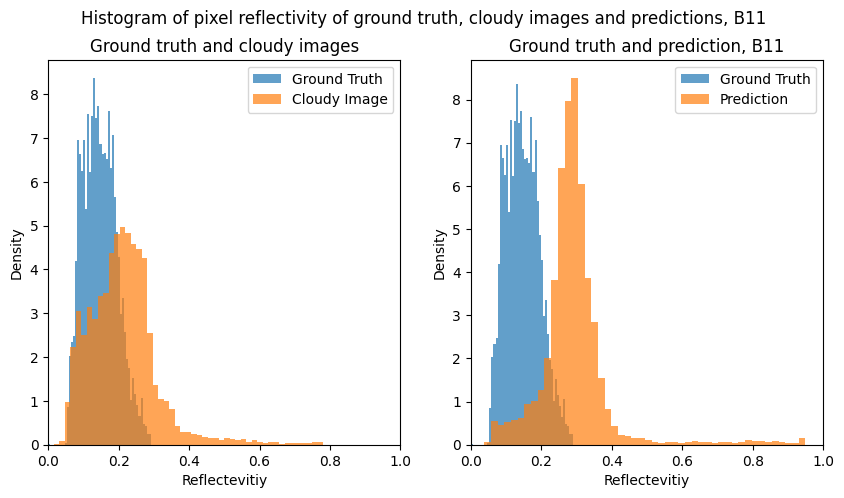

In [135]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]


axs[0].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

In [136]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r>0

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only cloudy pixels, B11')

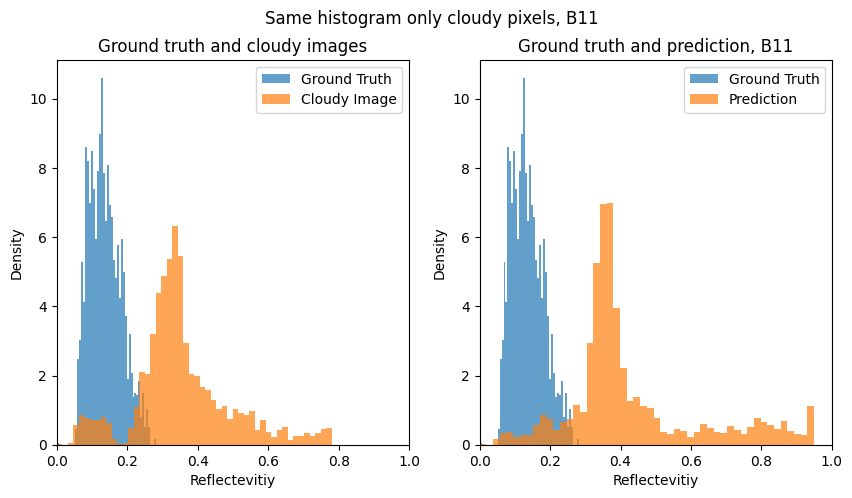

In [137]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only cloudy pixels, B11')

In [138]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==0

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only clear pixels, B11')

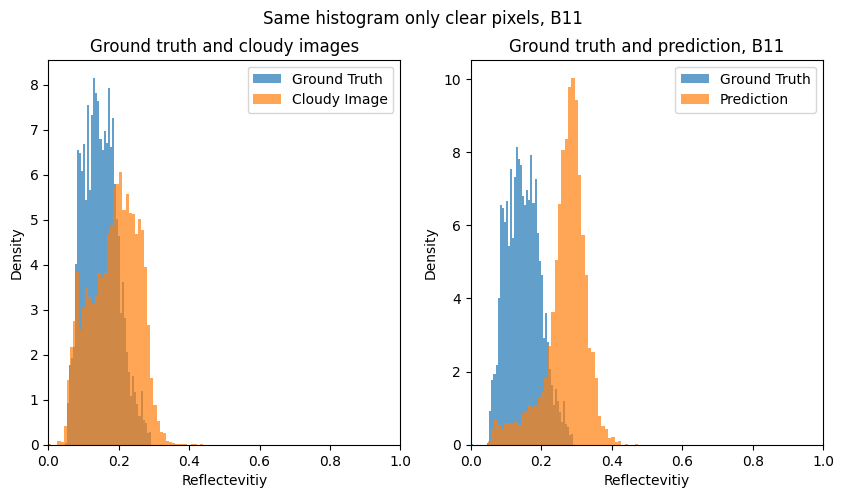

In [139]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only clear pixels, B11')

In [140]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==1

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only thin cloud pixels, B11')

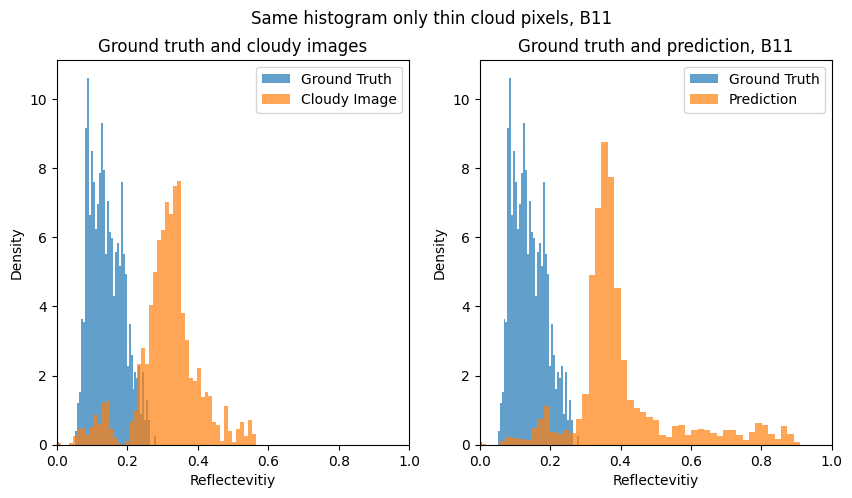

In [141]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thin cloud pixels, B11')

In [142]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==2

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only thick cloud pixels, B11')

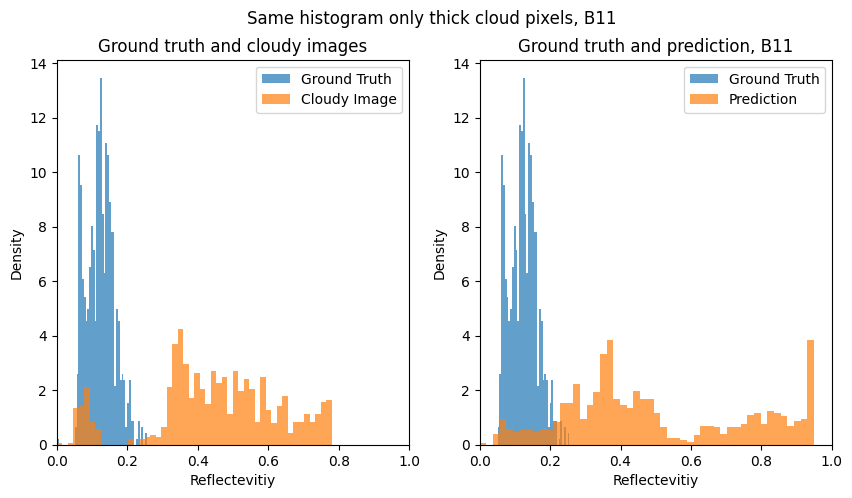

In [143]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thick cloud pixels, B11')

In [144]:
res=clear_array-pred_array

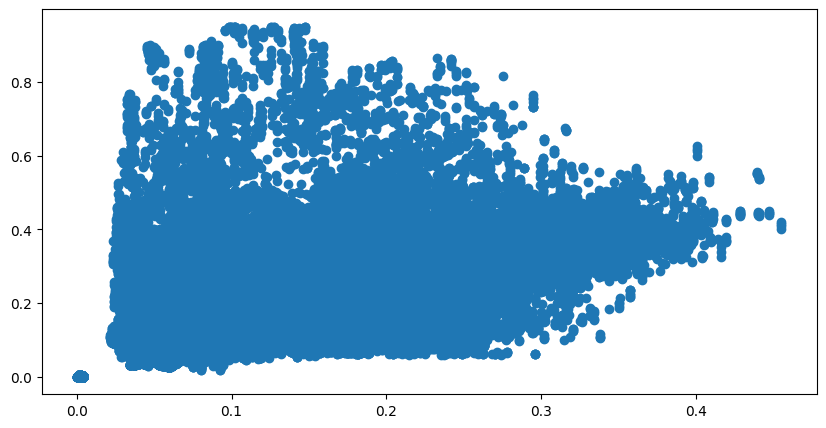

In [145]:
plt.scatter(clear_array,pred_array)

In [146]:
band=10
## Prediction v Ground Truth ##
y_true_11=clear_array[:,band]
pred_y_11=pred_array[:,band]
bins=np.linspace(0,0.6,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

clear_true=clear_array[cloud_mask_array==0,:]
thin_true=clear_array[cloud_mask_array==1,:]
semi_true=clear_array[cloud_mask_array==2,:]

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

clear_pred=pred_array[cloud_mask_array==0,:]
thin_pred=pred_array[cloud_mask_array==1,:]
semi_pred=pred_array[cloud_mask_array==2,:]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred


        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero


        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin


        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med



/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Ground truth over prediction, Real data')

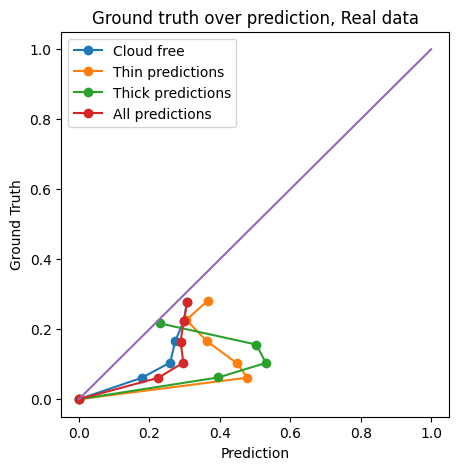

In [147]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Thick predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, Real data")

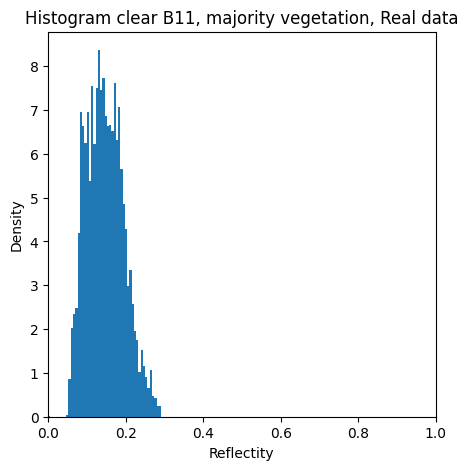

In [148]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(clear_array[:,10],bins=50,density=True)
plt.xlim([0,1])
plt.title('Histogram clear B11, majority vegetation, Real data')
plt.xlabel('Reflectity')
plt.ylabel('Density')
plt.show()

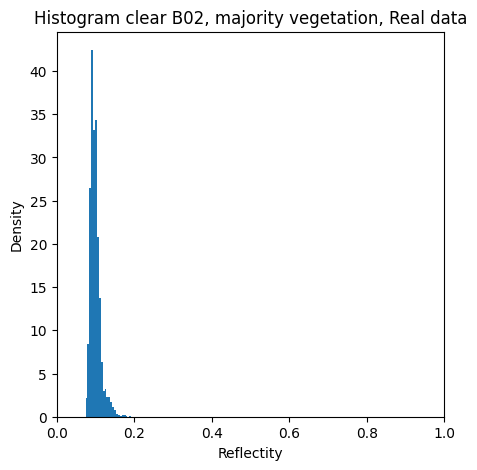

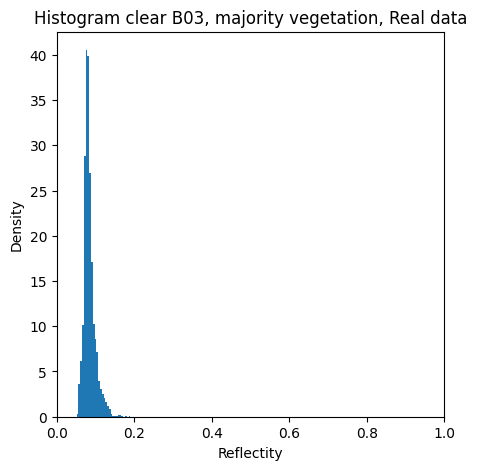

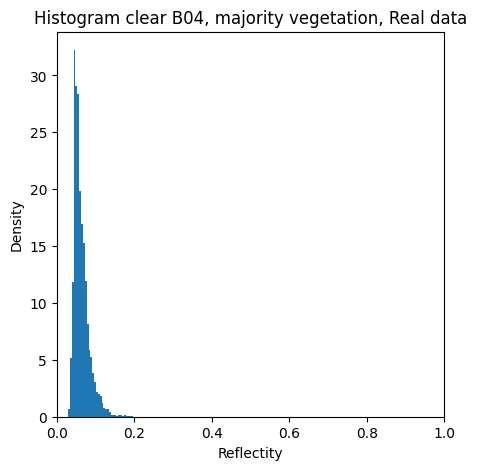

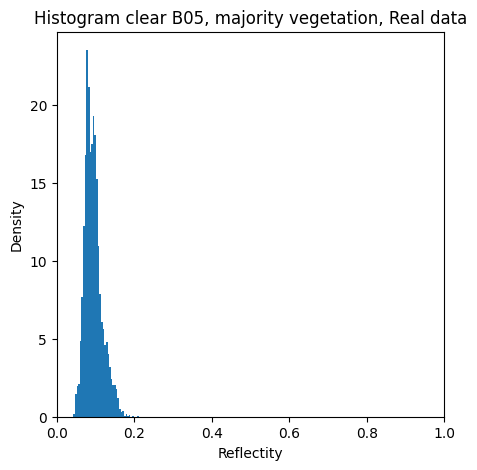

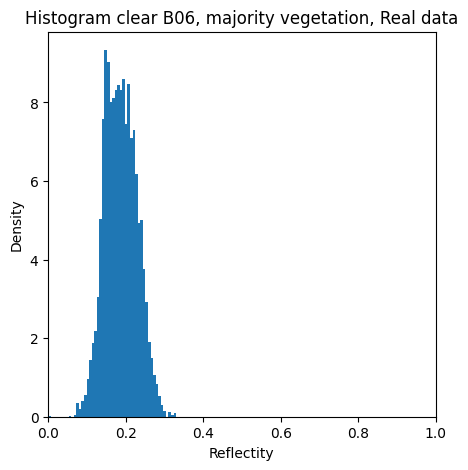

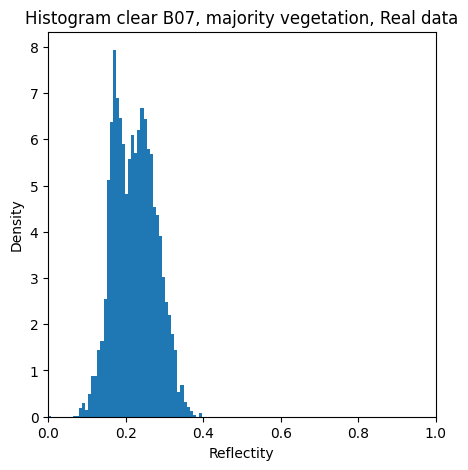

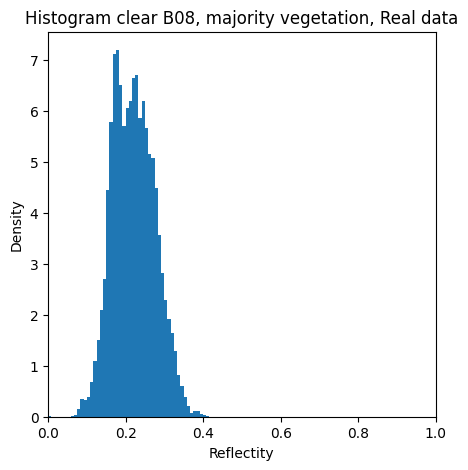

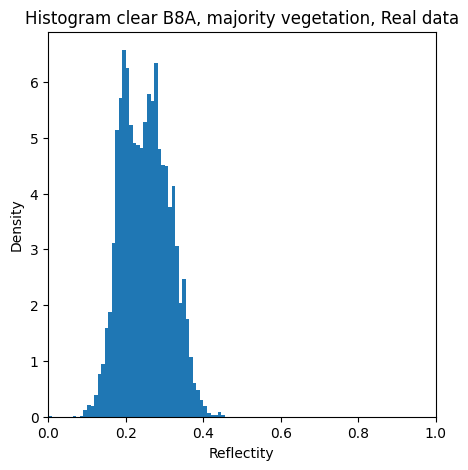

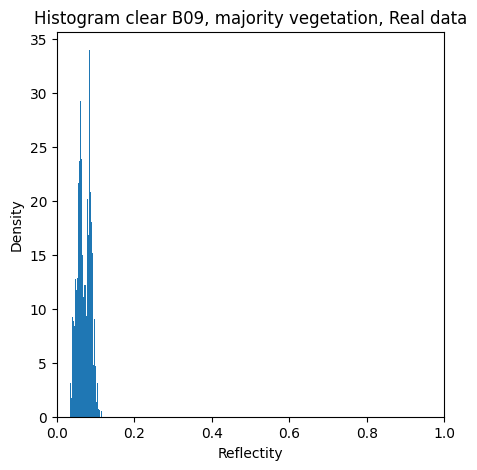

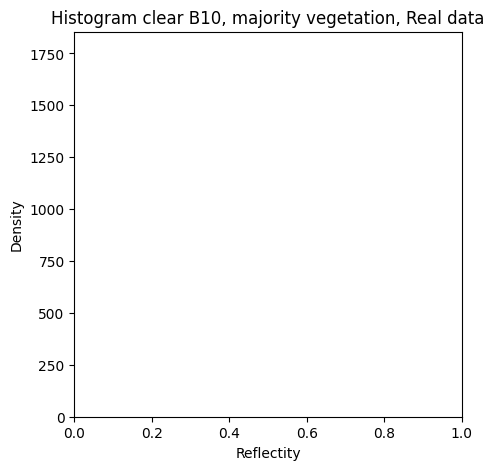

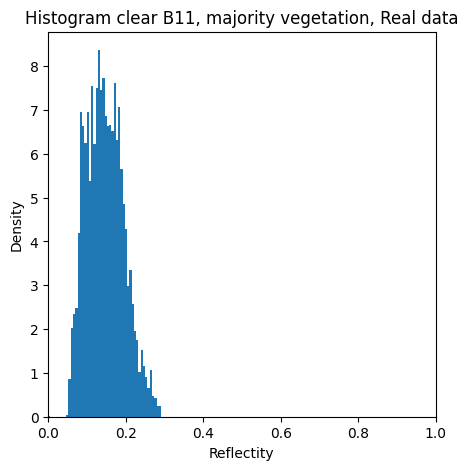

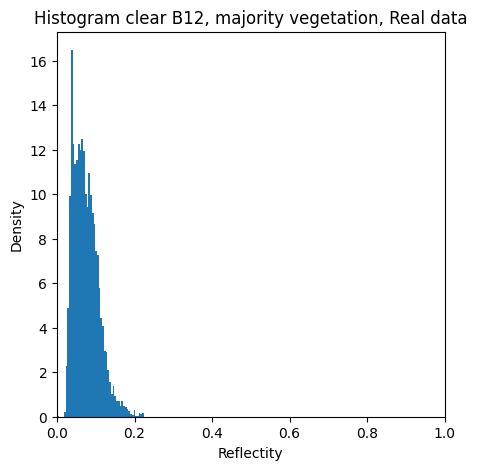

In [149]:
plt.rcParams["figure.figsize"] = [5, 5]
for band in range(0,12):

    plt.hist(clear_array[:,band],bins=50,density=True)
    plt.xlim([0,1])
    if band<7: 
        plt.title('Histogram clear B0'+str(band+2)+', majority vegetation, Real data')
    elif band==7:
        plt.title('Histogram clear B8A, majority vegetation, Real data')
    elif band==8:
        plt.title('Histogram clear B09, majority vegetation, Real data')
    else:
        plt.title('Histogram clear B'+str(band+1)+', majority vegetation, Real data')
    plt.xlabel('Reflectity')
    plt.ylabel('Density')
    plt.show()